# Importation des données

'all_data_v2.0_avec_conso_gaz.csv' contient toutes les données indexées par maille iris référencées par le code 'id_iris'. Les tags sont les colonnes sur lesquelles sera appliqué le clust. 'df' est une abbréviation pour dataframe.

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
df_origin= pd.read_csv('all_data_v2.0_avec_conso_gaz.csv', delimiter=';')
df_origin_position= df_origin[['id_iris','lon','lat']]

#INDEXATION PAR LE CODE IRIS
tags = ['id_iris','c_elec_conso_tot_res',
       'c_elec_conso_tot_agr', 'c_elec_conso_tot_indus',
       'c_elec_conso_tot_tert', 'p_elec_prod_pv',
       'p_elec_prod_eol','p_elec_prod_bio','p_elec_prod_coge','socioeco_revenu_med','ensol',
       'c_gaz_conso_res','c_gaz_conso_tert','c_gaz_conso_indus','c_gaz_conso_indus','c_gaz_conso_agr']
df_origin_group=df_origin.groupby(['id_iris'])
#df_origin_group1=df_origin_group.get_group('100150000')

# Modification des données 

Ici nous ajoutons des colonnes où les valeurs de consommation et de production sont divisées par le nombre d'habitants. 'df_origin_position' contient la latitude et la longitude des zones iris.

In [3]:
tags2 = ['c_elec_conso_tot_res',
       'c_elec_conso_tot_agr', 'c_elec_conso_tot_indus',
       'c_elec_conso_tot_tert', 'p_elec_prod_pv',
       'p_elec_prod_eol','p_elec_prod_bio','p_elec_prod_coge',
       'c_gaz_conso_res','c_gaz_conso_tert','c_gaz_conso_indus','c_gaz_conso_indus','c_gaz_conso_agr']
tags3=[s+'_par_hbts' for s in tags2]
test=df_origin[tags2].values/df_origin[['socioeco_npers']].values
df_origin[tags3]=pd.DataFrame(test)

tags3.append('id_iris')
df_origin=df_origin[tags3]
df_origin=df_origin.set_index(['id_iris'])
df_origin_position=df_origin_position.set_index(['id_iris'])

Nous pouvons être confrontés à un problème de valeurs manquantes que nous remplaçons ici par des zéros. 'df_woNan' renvoie à un tableau sans valeur manquantes (without NaN).
La dimension de nos données pouvant être trop élevée (typiquement un vecteur de dimension 20 à 30) pour être visualisée, par l'intermédiaire de l'algorithme t-SNE nous réduisons le problème à deux dimensions.

In [4]:
#REMPLISSAGE DES CASES VIDES PAR DES 0
df_woNan=df_origin.fillna(0)

#REDUCTION DE DIMENSION POUR VISUALISATION
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True) 

# Clustering

Il faut ici choisir les deux valeurs importantes pour l'analyse, le nombre de mailles IRIS ('nb_samples) et le nombre de clusters ('nb_clusters'). Pour information, avec un i7 et 16gb de ram, 30000 mailles en dimension 30 ont été processées en cinq minutes.

In [5]:
nb_samples=1000#len(df_woNan.index)
nb_clusters=10

On fait un tirage aléatoire pour ne pas être biaisé par la proximité géographique dans le cas d'un nombre d'échantillons limité. On fait un premier affichage à deux dimensions sans clustering.

In [6]:
import random
random_idx=random.sample(range(len(df_woNan.index)), nb_samples)

ndarray_tsne=model.fit_transform(df_woNan.iloc[random_idx]) 
df_tsne=pd.DataFrame(ndarray_tsne,columns=['a', 'b'])
df_tsne.plot.scatter(x='a', y='b');

On utilise ici un algorithme de clustering non-supervisé à 'nb_clusters' classes par AgglomerativeClustering qui effctue un clustering hiérarchique de type Ward.

In [7]:
import time
start_time = time.time()
from sklearn.cluster import AgglomerativeClustering
hierarch_cluster=AgglomerativeClustering(n_clusters=nb_clusters)
cluster_nmb= np.zeros(shape=(nb_samples,1))
cluster_nmb=hierarch_cluster.fit_predict(df_tsne, y=cluster_nmb)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.17891788482666016 seconds ---


# Affichage des clusters

'plot_clustering' permet d'afficher la matrice à deux colonnes 'X_red' à partir d'une liste unidimensionnée 'labels'. La première commande affiche les clusters par des numéros colorés sur la projection 2D t-SNE ci-dessus. Le second affiche une carte de France avec les mêmes clusters.

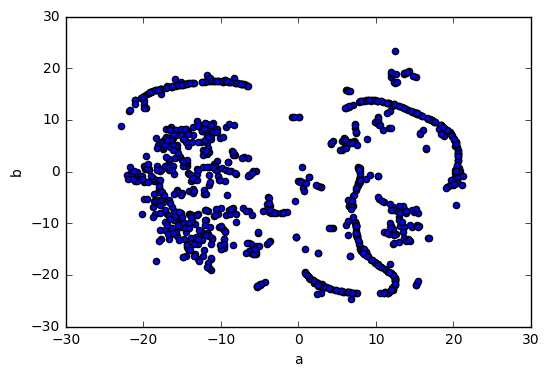

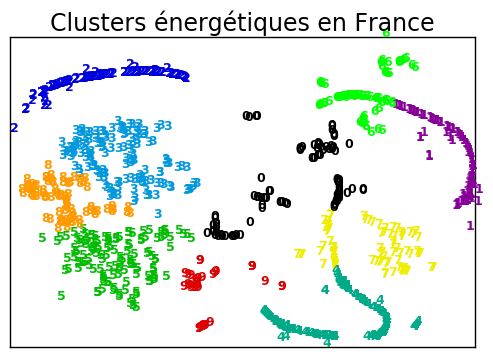

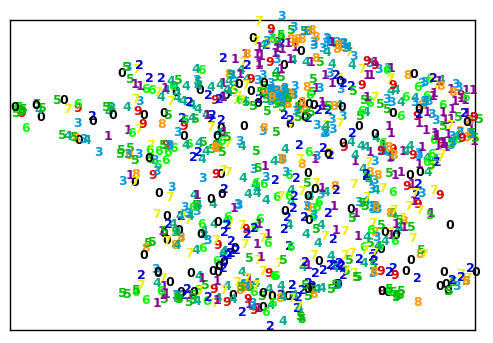

In [8]:
from matplotlib import pyplot as plt
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(labels[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('on')
    plt.show()
plot_clustering(df_tsne.as_matrix(), hierarch_cluster.labels_,"Clusters énergétiques en France")

df_origin_position_small=df_origin_position.iloc[random_idx]
plot_clustering(df_origin_position_small.as_matrix(), cluster_nmb, title=None)

# Analyse complémentaire

On fait ici une analyse des valeurs moyennes sur les clusters si un expert souhaite leur donner une signification. On effectue ensuite un algorithme des trois plus proches voisins (4 car le point dont on cherche les voisins est son plus proche voisin).

In [9]:
#AJOUT DU NUMERO DU CLUSTER
df_woNan_selec=df_woNan.iloc[random_idx]
df_woNan_selec['cluster']=hierarch_cluster.labels_

#STATISTIQUES PAR CLUSTER
df_woNan_selec_group=df_woNan_selec.groupby('cluster')
df_woNan_selec_stats=df_woNan_selec_group.mean()

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(df_woNan)
distances, indices_ordonnes = nbrs.kneighbors(df_woNan)

iris_array=df_origin.index.values
def index_to_iris(i):
    return iris_array[i]

indices_iris=index_to_iris(indices_ordonnes)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Export des données des plus proches voisins IRIS au format csv.

In [10]:
output=pd.DataFrame(test2, columns=['id_iris','id_iris_voisin1','id_iris_voisin2','id_iris_voisin3'])
#output['Classe']=cluster_nmb
output.to_csv('plus_proches_voisins.csv', sep=';', index=False)

NameError: name 'test2' is not defined